In [ ]:
!apt-get -y install fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [ ]:
!pip install shap scikit-learn joblib

In [ ]:
# 데이터 로드
!gdown 1G7K6jL3MiZl9-Bnz9ux-20CQ2DjZ0y_L

## shap 분석  

In [4]:
# 데이터 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/final_analysis_v3_cleaned_full.csv")

# 라벨 인코딩
for col in ["대분류명", "행정동", "시군구"]:
    df[col + "_인코딩"] = LabelEncoder().fit_transform(df[col])

# 수치형 변환
for col in ['지역화폐가맹률', '폐업률', '총방문인구수', '건당_평균_결제금액', '역세권점포비율', '총이용금액']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors="coerce")

# 로그 변환
for col in ['총방문인구수', '총주거인구수', '총이용금액']:
    df[col] = np.log1p(df[col])

# 파생 변수 생성
df['가맹률_이동평균'] = df.groupby(['시군구', '행정동'])['지역화폐가맹률'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['가맹률_추세'] = df['지역화폐가맹률'] - df['가맹률_이동평균']
df['월'] = pd.to_datetime(df['기준연월']).dt.month

# y값 정의 (폐업률이 0보다 크면 페업(1), 아니면 영업중(0))
df["폐업여부"] = (df["폐업률"] > 0).astype(int)
y = df["폐업여부"]

# 피처 정의 (모델링 코드에서 상관관계 및 vif 계산하여 선정한 피처)
features = ['여성비율_방문', '저녁_소비비율', '30대_비율', '월별_총거래금액',
            '지역화폐가맹률', '총방문인구수', '총이용금액', '건당_평균_결제금액',
            '대분류명_인코딩', '시군구_인코딩', '행정동_인코딩', '가맹률_추세', '총주거인구수', '역세권점포비율']
X = df[features].fillna(0).astype("float32")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import joblib, shap

# 모델 로드
model = joblib.load("xgb_final_model.pkl")

X_sample = X_train.sample(n=5000, random_state=42) # 샘플링

explainer = shap.Explainer(model, X_sample) # SHAP 값 계산
shap_values = explainer(X_sample)

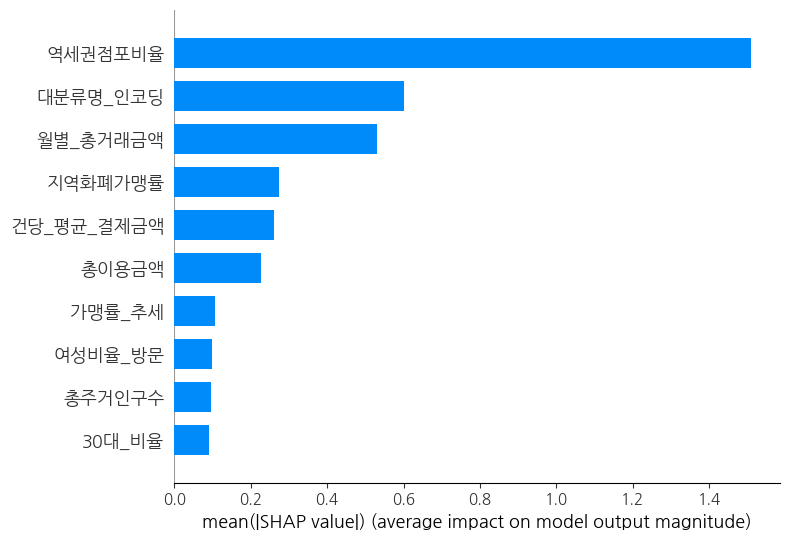

In [12]:
# shap 중요도 시각화
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=10)

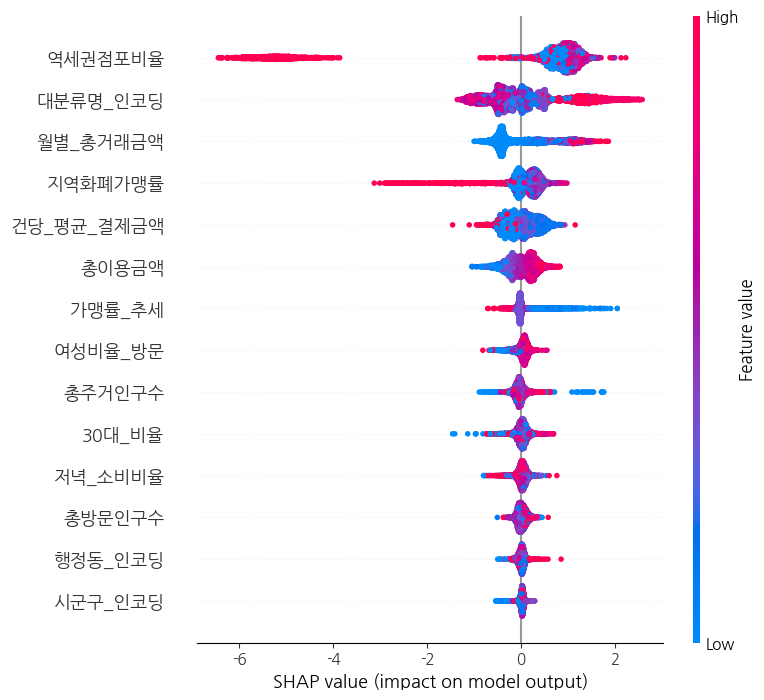

In [7]:
shap.summary_plot(shap_values, X_sample)

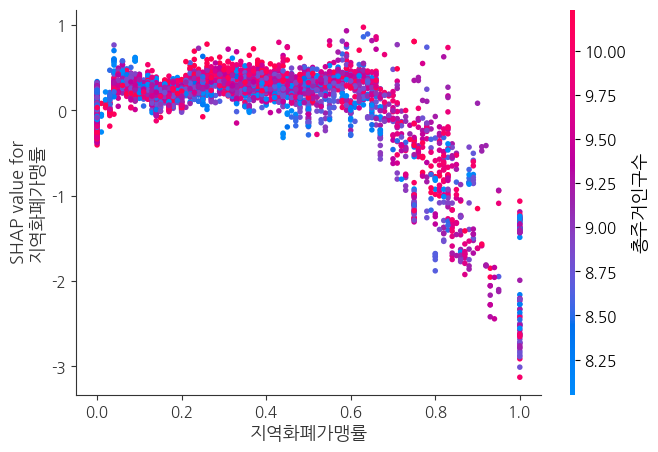

In [14]:
shap_vals_array = shap_values.values
expected_value = shap_values.base_values

shap.dependence_plot('지역화폐가맹률', shap_vals_array, X_sample)

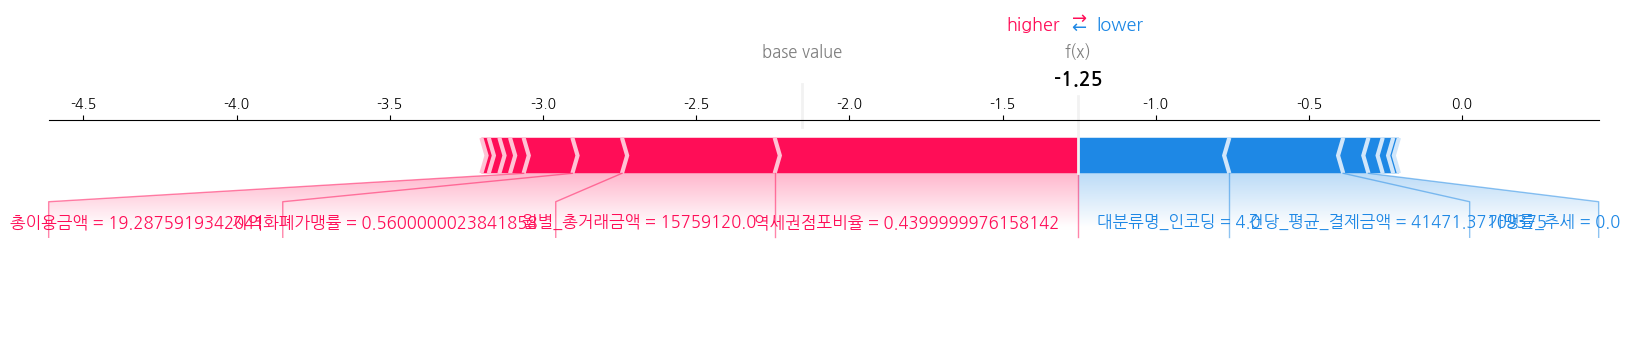

In [15]:
# 첫 번째 샘플 기준 force plot
shap.plots.force(
    expected_value[0],
    shap_vals_array[0],
    X_sample.iloc[0],      # 첫 샘플의 입력값
    matplotlib=True        # 코랩에서 보기 좋게
)


# 모델 예측값 기반 위험 지수 계산
모델 예측 확률과 정책 취약 지표를 합산한 후 0~1 범위로 표준화하여 폐업 위험도 지수를 산출

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 모델 예측 확률 추가
pred_probs = model.predict_proba(df[features].fillna(0).astype(np.float32))[:, 1]

# 위험 점수 계산 (모델 예측결과 비중: 0.8)
df = df.reset_index(drop=True)
df["pred_prob"] = pred_probs
df["위험점수_raw"] = (
    pred_probs * 0.8 +                 # 모델 예측 확률 80% 반영
    (1 - df["지역화폐가맹률"]) * 0.1 +
    (1 - df["총방문인구수"]) * 0.05 +
    (1 - df["역세권점포비율"]) * 0.05
)

# 정규화
scaler = MinMaxScaler()
df["위험점수"] = scaler.fit_transform(df[["위험점수_raw"]])

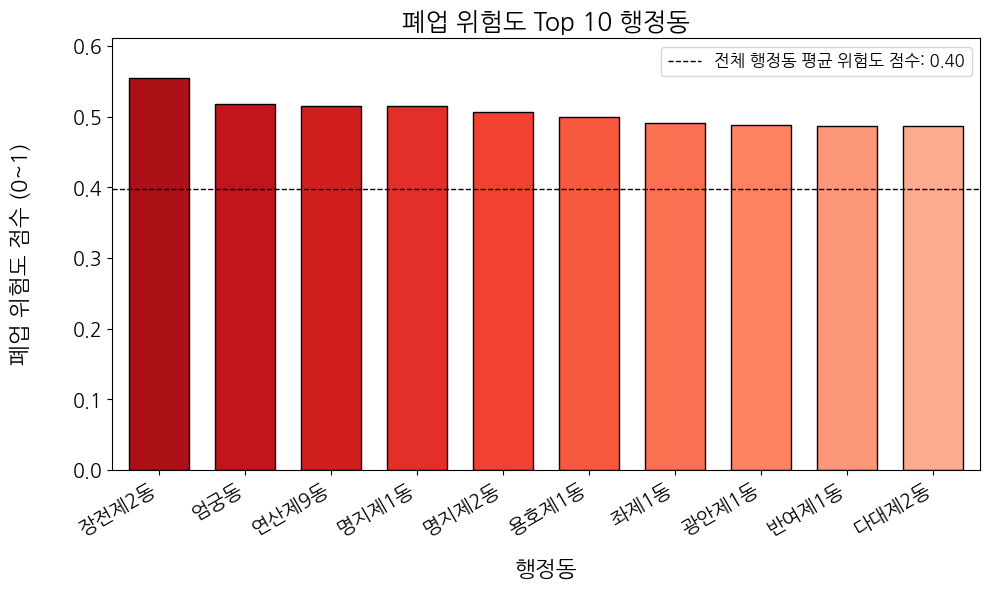

In [ ]:
# 행정동별 평균 위험 점수 계산
top10_dong_norm = (
    df.groupby("행정동")["위험점수"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# 전체 평균 위험도 계산
avg_risk_score = df["위험점수"].mean()

# 색상 설정
colors = cm.Reds(np.linspace(0.3, 0.85, len(top10_dong_norm)))

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(
    top10_dong_norm["행정동"],
    top10_dong_norm["위험점수"],
    color=colors[::-1],  # 색상 반전
    edgecolor="black",
    width=0.7
)

# 전체 평균 점선 및 범례
plt.axhline(
    avg_risk_score,
    color="black",
    linestyle="--",
    linewidth=1.,
    label=f"전체 행정동 평균 위험도 점수: {avg_risk_score:.2f}"
)
plt.legend(fontsize=12, loc="upper right")

plt.xlabel("행정동", fontsize=16, labelpad=15)
plt.ylabel("폐업 위험도 점수 (0~1)", fontsize=16, labelpad=30)
plt.title("폐업 위험도 Top 10 행정동", fontsize=18)
plt.xticks(rotation=30, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, top10_dong_norm["위험점수"].max() * 1.1)
plt.margins(x=0.02)

plt.tight_layout()
plt.show()

In [ ]:
top10_dong_norm

,행정동,위험점수
0,장전제2동,0.555250
1,엄궁동,0.518265
2,연산제9동,0.515477
3,명지제1동,0.514720
4,명지제2동,0.507009
5,용호제1동,0.499884
6,좌제1동,0.491588
7,광안제1동,0.488675
8,반여제1동,0.486818
9,다대제2동,0.486711


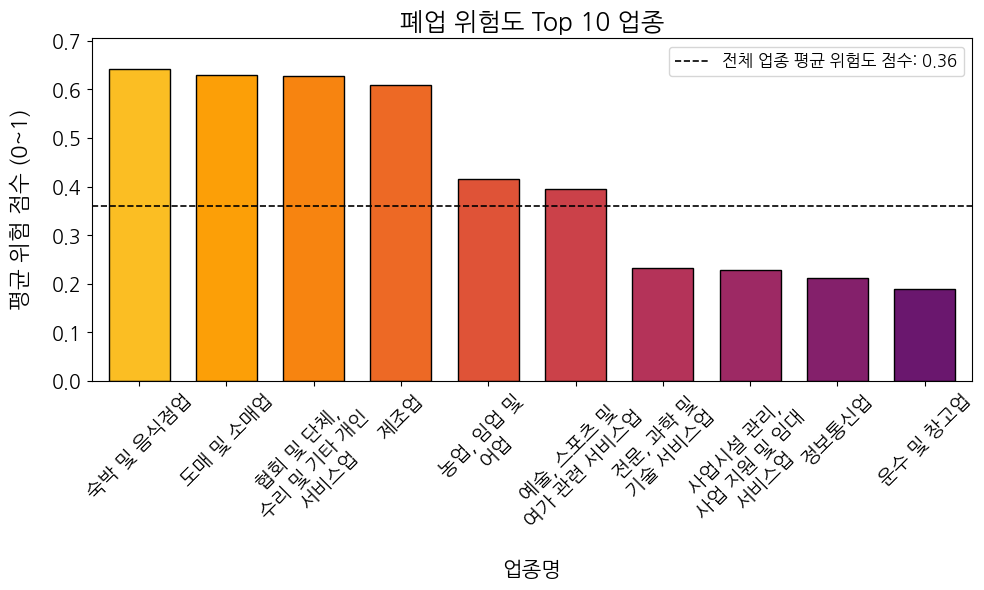

In [ ]:
import matplotlib.cm as cm
import textwrap

# 업종명 복원
encoder = LabelEncoder()
encoder.fit(df["대분류명"])
df["대분류명_복원"] = encoder.inverse_transform(df["대분류명_인코딩"])

# 업종별 평균 위험도 계산
industry_risk = (
    df.groupby("대분류명_복원")["위험점수"]
    .mean()
    .sort_values(ascending=False)
    .head(10)  # 위험도 Top 10 업종
)

# 전체 업종 위험도 평균치 계산
avg_industry_risk = df.groupby("대분류명_복원")["위험점수"].mean().mean()

# 업종명 자동 줄바꿈
industry_risk.index = [
    "\n".join(textwrap.wrap(label, 10)) for label in industry_risk.index
]

# 색상 설정
colors = cm.inferno(np.linspace(0.3, 0.85, len(industry_risk)))[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(
    industry_risk.index,
    industry_risk.values,
    color=colors,
    edgecolor="black",
    width=0.7
)

# 평균선
plt.axhline(
    avg_industry_risk,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label=f"전체 업종 평균 위험도 점수: {avg_industry_risk:.2f}"
)
plt.legend(fontsize=12, loc="upper right")

plt.ylabel("평균 위험 점수 (0~1)", fontsize=16, labelpad=15)
plt.xlabel("업종명", fontsize=15, labelpad=16)
plt.title("폐업 위험도 Top 10 업종", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, industry_risk.values.max() * 1.1)
plt.subplots_adjust(bottom=0.3)
plt.margins(x=0.02)

plt.tight_layout()
plt.show()


In [ ]:
industry_risk

,위험점수
숙박 및 음식점업,0.641057
도매 및 소매업,0.629578
"협회 및 단체,\n수리 및 기타 개인\n서비스업",0.628462
제조업,0.608274
"농업, 임업 및\n어업",0.415924
"예술, 스포츠 및\n여가 관련 서비스업",0.395931
"전문, 과학 및\n기술 서비스업",0.233011
"사업시설 관리,\n사업 지원 및 임대\n서비스업",0.227879
정보통신업,0.211166
운수 및 창고업,0.189947


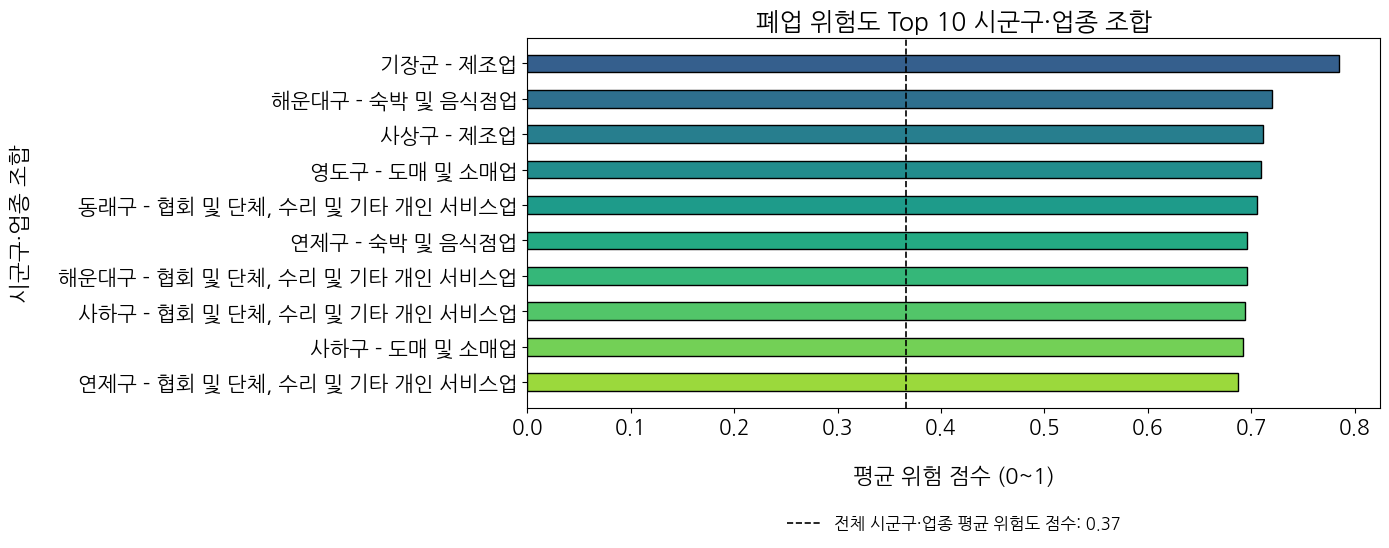

In [ ]:
# 시군구 라벨인코딩 복원
gu_encoder = LabelEncoder()
gu_encoder.fit(df["시군구"])
df["시군구_복원"] = gu_encoder.inverse_transform(df["시군구_인코딩"])

# 업종 라벨인코딩 복원
ind_encoder = LabelEncoder()
ind_encoder.fit(df["대분류명"])
df["대분류명_복원"] = ind_encoder.inverse_transform(df["대분류명_인코딩"])

# 구+업종 조합별 평균 위험 점수 계산
top10_gu_ind = (
    df.groupby(["시군구_복원", "대분류명_복원"])["위험점수"]
    .mean()
    .sort_values(ascending=False)  # 위험도 높은 순서
    .head(10)
    .reset_index()
)

top10_gu_ind["조합"] = top10_gu_ind["시군구_복원"] + " - " + top10_gu_ind["대분류명_복원"]
avg_gu_ind_risk = df.groupby(["시군구_복원", "대분류명_복원"])["위험점수"].mean().mean()

colors = cm.viridis(np.linspace(0.3, 0.85, len(top10_gu_ind)))

plt.figure(figsize=(14, 6))
plt.barh(
    top10_gu_ind["조합"][::-1],  # 위험 점수 높은 조합이 위로 오도록
    top10_gu_ind["위험점수"][::-1],
    color=colors[::-1],
    edgecolor="black",
    height=0.5
)
plt.tight_layout(pad=1.5)

# 평균선
plt.axvline(
    avg_gu_ind_risk,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label=f"전체 시군구·업종 평균 위험도 점수: {avg_gu_ind_risk:.2f}"
)
plt.legend(
    fontsize=12,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),
    frameon=False
)

# 스타일 업그레이드
plt.xlabel("평균 위험 점수 (0~1)", fontsize=16, labelpad=20)
plt.ylabel("시군구·업종 조합", fontsize=16, labelpad=20)
plt.title("폐업 위험도 Top 10 시군구·업종 조합", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()


In [ ]:
top10_gu_ind

,시군구_복원,대분류명_복원,위험점수,조합
0,기장군,제조업,0.785309,기장군 - 제조업
1,해운대구,숙박 및 음식점업,0.720398,해운대구 - 숙박 및 음식점업
2,사상구,제조업,0.711601,사상구 - 제조업
3,영도구,도매 및 소매업,0.709607,영도구 - 도매 및 소매업
4,동래구,"협회 및 단체, 수리 및 기타 개인 서비스업",0.705221,"동래구 - 협회 및 단체, 수리 및 기타 개인 서비스업"
5,연제구,숙박 및 음식점업,0.696412,연제구 - 숙박 및 음식점업
6,해운대구,"협회 및 단체, 수리 및 기타 개인 서비스업",0.695971,"해운대구 - 협회 및 단체, 수리 및 기타 개인 서비스업"
7,사하구,"협회 및 단체, 수리 및 기타 개인 서비스업",0.693639,"사하구 - 협회 및 단체, 수리 및 기타 개인 서비스업"
8,사하구,도매 및 소매업,0.691737,사하구 - 도매 및 소매업
9,연제구,"협회 및 단체, 수리 및 기타 개인 서비스업",0.687033,"연제구 - 협회 및 단체, 수리 및 기타 개인 서비스업"


# 성과 지표 계산  

In [ ]:
!gdown 12ctuq9pdlZ2GWRj7EuK-BQ-XoEZviCim

In [ ]:
import pandas as pd
df = pd.read_csv("/content/gold.busan.cluster_k4 (1).csv", encoding="utf-8-sig")
df

In [ ]:
# 위험지역 제외한 평균 폐업률
non_danger_df = df[df["cluster"] != 3]
avg_closure_rate_non_danger = round(non_danger_df["폐업률"].mean() * 100, 2)
print(f"위험지역 제외 전체 상권 평균 폐업률: {avg_closure_rate_non_danger:.2f}%")

In [ ]:
# 위험지역 제외한 평균 지역화폐 가맹률
avg_card_rate_non_danger = round(non_danger_df["지역화폐가맹률"].mean() * 100, 2)
print(f"위험지역 제외 전체 상권 평균 지역화폐 가맹률: {avg_card_rate_non_danger:.2f}%")

In [ ]:
# 위험지역의 평균 폐업률, 가맹률
danger_df = df[df["cluster"] == 3]

avg_closure_rate_danger = round(danger_df["폐업률"].mean() * 100, 2)
avg_card_rate_danger = round(danger_df["지역화폐가맹률"].mean() * 100, 2)

print(f"위험지역 평균 폐업률: {avg_closure_rate_danger:.2f}%")
print(f"위험지역 평균 지역화폐 가맹률: {avg_card_rate_danger:.2f}%")

In [ ]:
# 기회지역의 평균 폐업률, 가맹률
danger_df = df[df["cluster"] == 2]

avg_closure_rate_danger = round(danger_df["폐업률"].mean() * 100, 2)
avg_card_rate_danger = round(danger_df["지역화폐가맹률"].mean() * 100, 2)

print(f"기회지역 평균 폐업률: {avg_closure_rate_danger:.2f}%")
print(f"기회지역 평균 지역화폐 가맹률: {avg_card_rate_danger:.2f}%")